# Positive feedback with cooperativity
Indirect or direct positive feedback that is characterized by a kinetic order > 1. A simple model is illustrated by the mechanism below. $\beta$ and v are basal and maximal synthesis rates of A. K is the equilibrium dissociation constant for the dimer to the promoter.

<img src='feedback.png',width=250>

\begin{equation}
\frac{dA}{dt}=\beta+\frac{vA_2}{K+A_2}-2k_aA^2+2k_dA_2-k_{deg}A \\
\frac{dA_2}{dt}=2k_aA^2-2k_dA_2-k_{deg}A_2
\end{equation}

## 1 Trajectory
Dynamic profile of A and $A_2$ vs. time.

In [30]:
#Rate equations
def dA(A,A_2,t,params,dt):
    dA=(params[0]+(params[1]*A_2)/(params[2]+A_2)-2*params[3]*(A*A)+2*params[4]*A_2-params[5]*A)*dt
    return dA

def dA_2(A,A_2,t,params,dt):
    dA_2=(2*params[3]*A*A-2*params[4]*A_2-params[5]*A_2)*dt
    return dA_2

In [31]:
#Trajectory function
def trajectory(params,dt,init,t):
    import pandas as pd
    run=pd.DataFrame(columns=['A','A_2','t'])
    run=run.append(pd.DataFrame(data={'A':[init[0]],'A_2':[init[1]],'t':[0]}))
    while list(run['t'])[len(run)-1]<t:
        nextA=dA(list(run['A'])[len(run)-1],list(run['A_2'])[len(run)-1],list(run['t'])[len(run)-1],params,dt)+list(run['A'])[len(run)-1]
        nextA_2=dA_2(list(run['A'])[len(run)-1],list(run['A_2'])[len(run)-1],list(run['t'])[len(run)-1],params,dt)+list(run['A_2'])[len(run)-1]
        nextt=list(run['t'])[len(run)-1]+dt
        run=run.append(pd.DataFrame(data={'A':[nextA],'A_2':[nextA_2],'t':[nextt]}))
    return run

In [32]:
#Set initial values, parameters, and run trajectory
init=[0.02,0] #[Ai,A_2i]
params=[0.2,0.8,0.8,1.5,0.3,0.4] #[beta,v,K,ka,kd,kdeg]
t=20
dt=0.1
run=trajectory(params,dt,init,t)

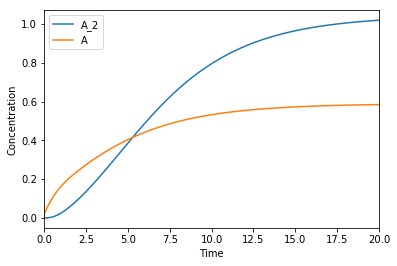

In [33]:
#Plot results
import matplotlib.pyplot as plt
plt.plot(run['t'],run['A_2'])
plt.plot(run['t'],run['A'])
plt.xlim(0,20)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

## 2 Steady-state
Equilibrium concentrations of A and $A_2$ at varying parameters and initial values.

In [34]:
def equations(x):
    out=[(params[0]+(params[1]*x[1])/(params[2]+x[1])-2*params[3]*(x[0]*x[0])+2*params[4]*x[1]-params[5]*x[0])]
    out.append(2*params[3]*x[0]*x[0]-2*params[4]*x[1]-params[5]*x[1])
    return out

def equilibrium():
    from scipy.optimize import fsolve
    import math
    Aeq=fsolve(equations,(1,1))
    return Aeq

In [35]:
import numpy as np
A=[]
A_2=[]
ka=list(np.arange(0,2,0.01))
for i in ka:
    #params=[0.2,0.8,0.8,i,0.3,0.4] 
    params=[0.2,0.8,0.3,i,0.3,0.4] #[beta,v,K,ka,kd,kdeg]
    Aeq=equilibrium()
    A.append(Aeq[0])
    A_2.append(Aeq[1])

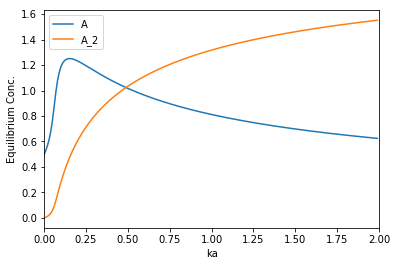

In [36]:
#Plot results
import matplotlib.pyplot as plt
import pandas as pd
out=pd.DataFrame({'A':A,'A_2':A_2,'ka':ka})
plt.plot(out['ka'],out['A'])
plt.plot(out['ka'],out['A_2'])
plt.legend(loc=0)
plt.xlim(0,2)
plt.xlabel('ka')
plt.ylabel('Equilibrium Conc.')
plt.show()

## 3 Finding bistability

In [47]:
import PyDSTool as dst
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# we must give a name
DSargs=dst.args(name='Positive feedback model')
# parameters
DSargs.pars={'B':0.2,
             'v':1.5,
             'K':0.8,
             'ka':1.5,
             'kd':0.3,
             'kdeg':0.4}
# rhs of the differential equation, including dummy variable w
DSargs.varspecs={'A':'B+(v*A_2)/(K+A_2)-2*ka*(A*A)+2*kd*A_2-kdeg*A',
                 'A_2':'2*ka*A*A-2*kd*A_2-kdeg*A_2'}
# initial conditions
DSargs.ics={'A':0.2,'A_2':0}

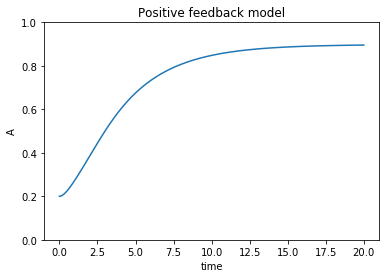

In [48]:
DSargs.tdomain=[0,20]                       # set the range of integration.
ode=dst.Generator.Vode_ODEsystem(DSargs)    # an instance of the 'Generator' class.
traj=ode.compute('bistability')             # integrate ODE
pts=traj.sample(dt=0.05)                    # Data for plotting

# PyPlot commands
plt.plot(pts['t'],pts['A'])
plt.xlabel('time')                          # Axes labels
plt.ylabel('A')                             # ...
plt.ylim([0,1])                             # Range of the y axis
plt.title(ode.name)                         # Figure title from model name
plt.show()

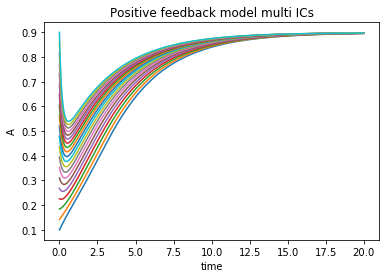

In [49]:
for i,A0 in enumerate(np.linspace(0.1,0.9,20)):
    ode.set(ics={'A':A0})                       # Initial condition
    # Trajectories are called pol0, pol1, ...
    # sample them on the fly to create Pointset tmp
    tmp=ode.compute('pol%3i'%i).sample()        # or specify dt option to sample to sub-sample
    plt.plot(tmp['t'],tmp['A'])
plt.xlabel('time')
plt.ylabel('A')
plt.title(ode.name+' multi ICs')
plt.show()

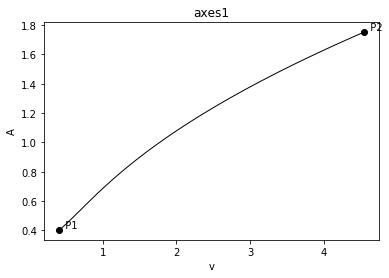

In [50]:
# Prepare the system to start close to a steady state
ode.set(pars={'v':0.5})       # Lower bound of the control parameter 'k1'
ode.set(ics={'A':0.2})         # Close to one of the steady states present for k1=6

PC=dst.ContClass(ode)        # Set up continuation class

PCargs=dst.args(name='EQ1',type='EP-C')       # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['v']                  # control parameter(s) (it should be among those specified in DSargs.pars)
PCargs.MaxNumPoints = 100                     # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 0.1
PCargs.MinStepSize  = 0.5
PCargs.StepSize     = 0.05
PCargs.LocBifPoints = 'LP'                    # detect limit points / saddle-node bifurcations
PCargs.SaveEigen    = True                    # to tell unstable from stable branches

PC.newCurve(PCargs)
PC['EQ1'].forward()
PC.display(['v','A'],stability=True,figure=1)        # stable and unstable branches as solid and dashed curves, resp.